In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import os
%matplotlib inline

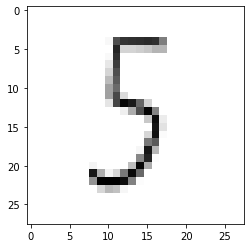

In [46]:
# Load new image
image_new = Image.open('image_classification/test_dataset/one.png')
plt.imshow(image_new)

In [3]:
# load the directory of all images
image_dir = os.listdir('image_classification/new_dataset/')
results_dir = os.listdir('image_classification/results/')

In [4]:
# load all images
image_list = []
results_list = {}
results_number_list = ['1','2','3','4','5']
for i in range(len(image_dir)):
    image_list.append(Image.open('image_classification/new_dataset/'+image_dir[i]))
for i in range(len(results_dir)):
    results_list.update({results_number_list[i]: Image.open('image_classification/results/'+results_dir[i])})

In [5]:
# get numpy array of all images
image_data_list = [np.asarray(image_list[i])[:,:,0].reshape(1,-1) for i in range(len(image_list))]

In [6]:
# create target data
y_1 = np.array([[1 for i in range(20)]])
y_2 = np.array([[2 for i in range(27)]])
y_3 = np.array([[3 for i in range(20)]])
y_4 = np.array([[4 for i in range(20)]])
y_5 = np.array([[5 for i in range(20)]])
y = np.c_[y_1,y_2,y_3,y_4,y_5].reshape(1,-1)
y = y[0]

In [7]:
# modify the dataset
X = np.array(image_data_list)
X = X[:,0,:]

In [8]:
# Shuffle the training and data set
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2,random_state=42)
for train_index, test_index in sss.split(X,y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

In [9]:
# check if 1 and 2 are split equally into train and test set
unique, counts = np.unique(y_train, return_counts=True)
counts

array([16, 21, 16, 16, 16], dtype=int64)

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

log_reg = Pipeline([
    ('scaler', StandardScaler()),
    ('log_regression', LogisticRegression(multi_class='ovr'))
])

#log_reg.fit(X_train, y_train)

In [35]:
from sklearn.svm import SVC, LinearSVC

svc_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc_classifier', LinearSVC(loss='hinge'))
])

svc_radial_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('svc_radial_classifier', SVC(kernel='linear', probability=True))
])

#svc_clf.fit(X_train, y_train)

In [12]:
# The predictions
y_pred_log = log_reg.predict(X_test)
y_pred_log_train = log_reg.predict(X_train)
y_pred_rbf = svc_clf.predict(X_test)
y_pred_rbf_train = svc_clf.predict(X_train)

NotFittedError: This StandardScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Evaluation
from sklearn.metrics import confusion_matrix

conf_mat_log = confusion_matrix(y_test, y_pred_log)
conf_mat_log

In [ ]:
conf_mat_svc_rbf = confusion_matrix(y_test, y_pred_rbf)
conf_mat_svc_rbf

In [13]:
# Fine tune the models
from sklearn.model_selection import GridSearchCV

param_grid = {'log_regression__C' : [0.001,0.01,0.1,1,10,100,1000]}
log_reg_tuned = GridSearchCV(log_reg, param_grid, cv=3, scoring='roc_auc_ovr')

log_reg_tuned.fit(X_train, y_train)
log_reg_tuned.best_params_

{'log_regression__C': 0.1}

In [14]:
y_pred_log_tuned = log_reg_tuned.predict(X_test)
conf_mat_log_tuned = confusion_matrix(y_test, y_pred_log_tuned)
conf_mat_log_tuned

NameError: name 'confusion_matrix' is not defined

In [26]:
param_grid = {'svc_classifier__C':[0.0000001,0.000001,0.00001,0.0001]}
linear_svc_tuned = GridSearchCV(svc_clf, param_grid, cv=3, scoring='accuracy')
linear_svc_tuned.fit(X_train, y_train)

linear_svc_tuned.best_params_

{'svc_classifier__C': 1e-07}

In [ ]:
y_pred_linear_svc_tuned = linear_svc_tuned.predict(X_test)
conf_mat_linear_svc_tuned = confusion_matrix(y_test, y_pred_linear_svc_tuned)
conf_mat_linear_svc_tuned

In [27]:
param_grid = {'svc_radial_classifier__C': [10**-10,0.00001,0.0001,0.001,0.01],
              'svc_radial_classifier__gamma':[10**-5,0.1,1,5,10,100]}

svc_radial_clf_tuned = GridSearchCV(svc_radial_clf, param_grid, cv=3, scoring = 'accuracy')
svc_radial_clf_tuned.fit(X_train, y_train)

svc_radial_clf_tuned.best_params_

{'svc_radial_classifier__C': 1e-10, 'svc_radial_classifier__gamma': 1e-05}

In [ ]:
y_pred_svc_radial_tuned = svc_radial_clf_tuned.predict(X_test)
conf_mat_svc_radial_tuned = confusion_matrix(y_test, y_pred_svc_radial_tuned)
conf_mat_svc_radial_tuned

In [36]:
from sklearn.ensemble import VotingClassifier

vot_clf = VotingClassifier(
            [('log_reg', log_reg_tuned),
             ('svc_radial', svc_radial_clf_tuned)],
            voting = 'soft')
vot_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('log_reg',
                              GridSearchCV(cv=3, error_score=nan,
                                           estimator=Pipeline(memory=None,
                                                              steps=[('scaler',
                                                                      StandardScaler(copy=True,
                                                                                     with_mean=True,
                                                                                     with_std=True)),
                                                                     ('log_regression',
                                                                      LogisticRegression(C=1.0,
                                                                                         class_weight=None,
                                                                                         dual=False,
                                              

In [ ]:
# wrong classified image
X_wrong = X_test[(y_test==5)&(y_pred==1)]
plt.imshow(X_wrong.reshape(28,28))

In [47]:
# Evaluate new image
new_image_data = np.asarray(image_new)[:,:,0].reshape(1,-1)
result_number = log_reg_tuned.predict(new_image_data)
log_reg_tuned.predict_proba(new_image_data)

array([[0.22237917, 0.12813664, 0.0505867 , 0.34233462, 0.25656288]])

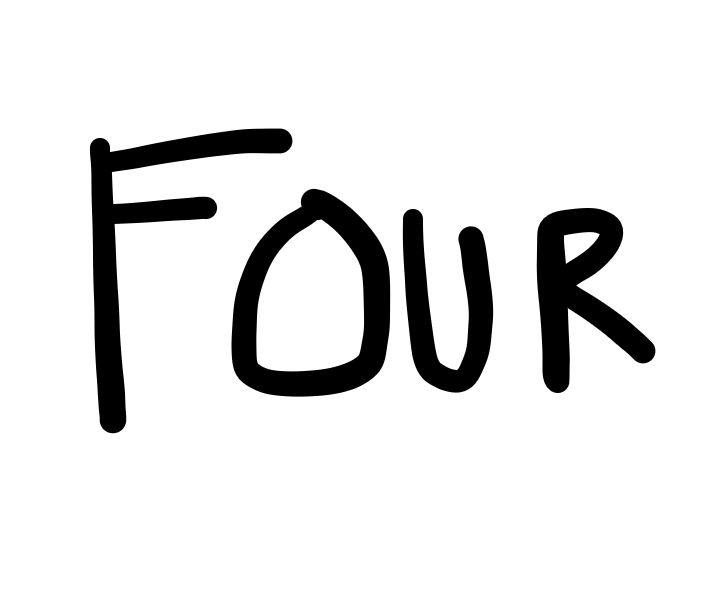

In [48]:
# Show the result
results_list[str(result_number[0])]

In [49]:
result_number = linear_svc_tuned.predict(new_image_data)
linear_svc_tuned.decision_function(new_image_data)

array([[ 2.52811922e-05, -6.44050558e-05, -5.32814681e-05,
         3.66454828e-05,  3.02598489e-05]])

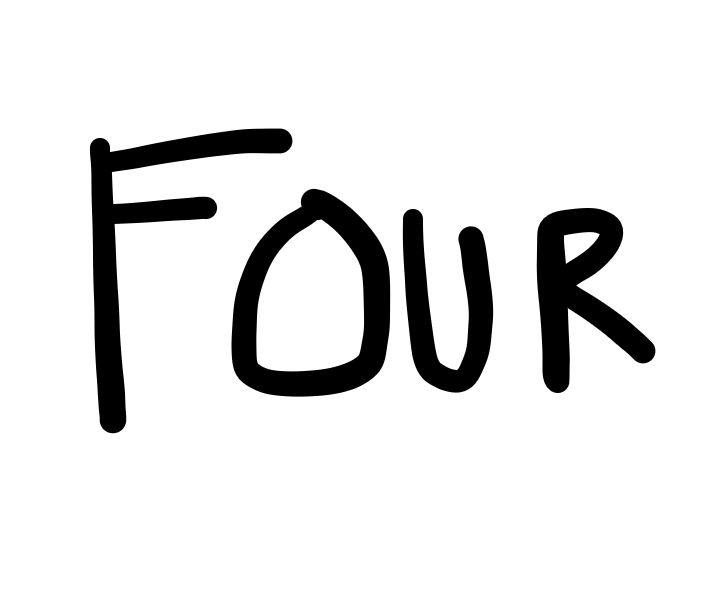

In [50]:
results_list[str(result_number[0])]

In [51]:
result_number = vot_clf.predict(new_image_data)
vot_clf.predict_proba(new_image_data)

array([[0.19603464, 0.18766614, 0.11578101, 0.26803133, 0.23248687]])

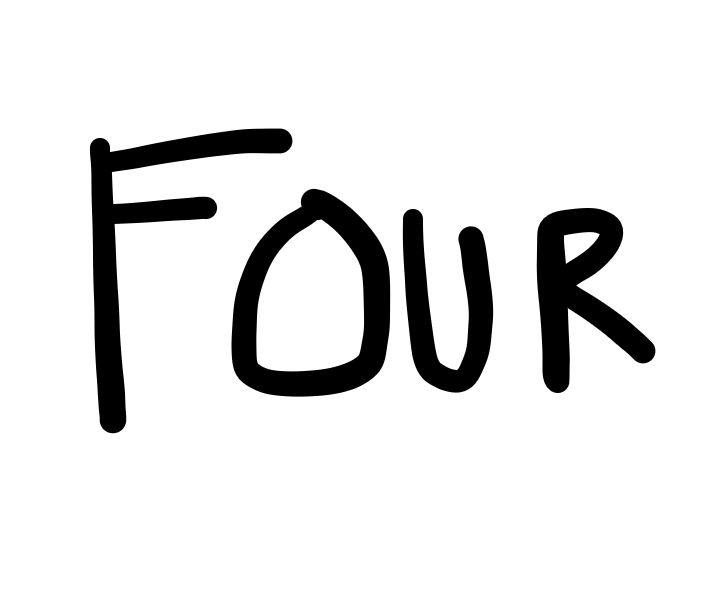

In [52]:
results_list[str(result_number[0])]